In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpb 
from sklearn.preprocessing import normalize

In [2]:
def generate_weighted_pinv(w, b, weighted=True): 
    w_1 = np.linalg.pinv(w)
    weighted_static = ((w_1.dot(b.T)).dot(np.linalg.pinv(b.dot(w_1.dot(b.T)))))
    if weighted is False: 
        return np.linalg.pinv(b)
    return weighted_static 

def generate_wrench(std, mean, ramp_idx, points): 
    noise = np.random.normal(mean,std,6*points).reshape((6,points))
    noise[ramp_idx] = np.linspace(0, 1, ramp_idx.shape[0] * points).reshape(ramp_idx.shape[0], points)
    return noise

def generate_weights(alpha_i, beta_i,motor_i, size):
    W = np.identity(size)
    W[np.arange(0, size-2, 3),np.arange(0, size-2, 3)] = alpha_i
    W[np.arange(1, size-1, 3),np.arange(1, size-1, 3)] = beta_i 
    W[np.arange(2, size, 3 ),np.arange(2, size, 3)] = motor_i 
    return W 
 
def print_matrix(matrix): 
    matrix = matrix.round(7)
    print("{")
    for i in range(matrix.shape[0]):
        string=""
        for j in range(matrix.shape[1]):
            string+= str(matrix[i, j]) + "f" + " ,"
        print(string)
    print("}")
    
def calc_actuator(c,wrench): 
    outputs = c.dot(wrench)
    actuators = c.shape[0] 
    alphas = outputs[np.arange(0, actuators-2, 3)]/outputs[np.arange(2, actuators, 3)]
    betas = outputs[np.arange(1, actuators-1, 3)]/outputs[np.arange(2, actuators, 3)]
    omegas = np.sqrt(np.abs(outputs[np.arange(2, actuators, 3)]))
    alphas = (np.remainder(alphas, np.pi) - (np.pi * 0.5)) * (180/np.pi)
    betas = (np.remainder(betas, np.pi) - (np.pi * 0.5)) * (180/np.pi)
    return alphas,betas, omegas 

In [12]:
mu = (1.6 *(10**-6))
Km = (2.58 * (10**-8))
L = 0.13
c = 0.707106781
A = L * mu
lamb = (7 * (10**-10))

coefficient_matrix2 = [ 
    [(-mu), 0.0,0.0, (-mu), 0.0,0.0,(-mu), 0.0,0.0, (-mu), 0.0, 0.0], 
    [ 0.0, (mu),0.0, 0.0, (mu), 0.0, 0.0, (mu), 0.0, 0.0, (mu), 0.0], 
    [ 0.0, 0.0, -(mu), 0.0,0.0, -(mu), 0.0,0.0, -(mu), 0.0,0.0, -(mu)], 
    [ (Km),0.0,(A ),  (Km),0.0,(-A), (-Km),0.0,(-A), (-Km),0.0, (A)], 
    [0, -Km , -A, 0, -Km , A, 0, Km, -A, 0, Km, A],
    [-A, -A, Km, A, A, Km, A, -A, -Km, -A, A, -Km ]
]

coefficient_matrix = [
     [(-mu), 0.0,0.0, (-mu), 0.0,0.0,(-mu), 0.0,0.0, (-mu), 0.0, 0.0], 
    [ 0.0, (mu),0.0, 0.0, (mu), 0.0, 0.0, (mu), 0.0, 0.0, (mu), 0.0], 
    [ 0.0, 0.0, -(mu), 0.0,0.0, -(mu), 0.0,0.0, -(mu), 0.0,0.0, -(mu)], 
    [ (Km),0.0,(A ),  (Km),0.0,(-A), (-Km),0.0,(-A), (-Km),0.0, (A)], 
    [0, -Km , -A, 0, -Km , A, 0, Km, -A, 0, Km, A],
    [0, 0, Km, 0, 0, Km, 0, 0, -Km, 0, 0, -Km ]
]


coeff_array = normalize(np.array(coefficient_matrix))
#coeff_array = np.array(coefficient_matrix2)
print(f" This is the condition number of the coefficient matrix {np.linalg.cond(coeff_array)}")

points = 1000
noise = np.random.normal(0.005,0.002,6*points).reshape((6,points)) 
noise[2] = 0.5
noise[5] = np.linspace(0.1, 1, points)
noise[1] *= ((15*np.pi)/180) * (1.94 * 9.81)
noise[0] *= ((15*np.pi)/180) * (1.94 * 9.81 )
noise[2] *= (9.81 * 2.5 * 1.94)
W = generate_weights(0.4, 0.4, 0.6, 12)
B = generate_weighted_pinv(W, coeff_array, weighted=True)
alphas,betas, omegas = calc_actuator(B, noise)
np.set_printoptions(suppress=True)
#print(repr(B.reshape((72,))))
print_matrix(B)
    


 This is the condition number of the coefficient matrix 1.0000000000000002
{
-0.5f ,0.0f ,0.0f ,0.0916272f ,-0.0f ,0.0f ,
0.0f ,0.5f ,-0.0f ,-0.0f ,-0.0916272f ,-0.0f ,
-0.0f ,0.0f ,-0.5f ,0.4924664f ,-0.4924664f ,0.5f ,
-0.5f ,0.0f ,0.0f ,0.0916272f ,-0.0f ,0.0f ,
0.0f ,0.5f ,-0.0f ,-0.0f ,-0.0916272f ,-0.0f ,
0.0f ,-0.0f ,-0.5f ,-0.4924664f ,0.4924664f ,0.5f ,
-0.5f ,-0.0f ,-0.0f ,-0.0916272f ,0.0f ,-0.0f ,
-0.0f ,0.5f ,-0.0f ,0.0f ,0.0916272f ,-0.0f ,
0.0f ,-0.0f ,-0.5f ,-0.4924664f ,-0.4924664f ,-0.5f ,
-0.5f ,-0.0f ,-0.0f ,-0.0916272f ,0.0f ,-0.0f ,
-0.0f ,0.5f ,-0.0f ,0.0f ,0.0916272f ,-0.0f ,
-0.0f ,-0.0f ,-0.5f ,0.4924664f ,0.4924664f ,-0.5f ,
}


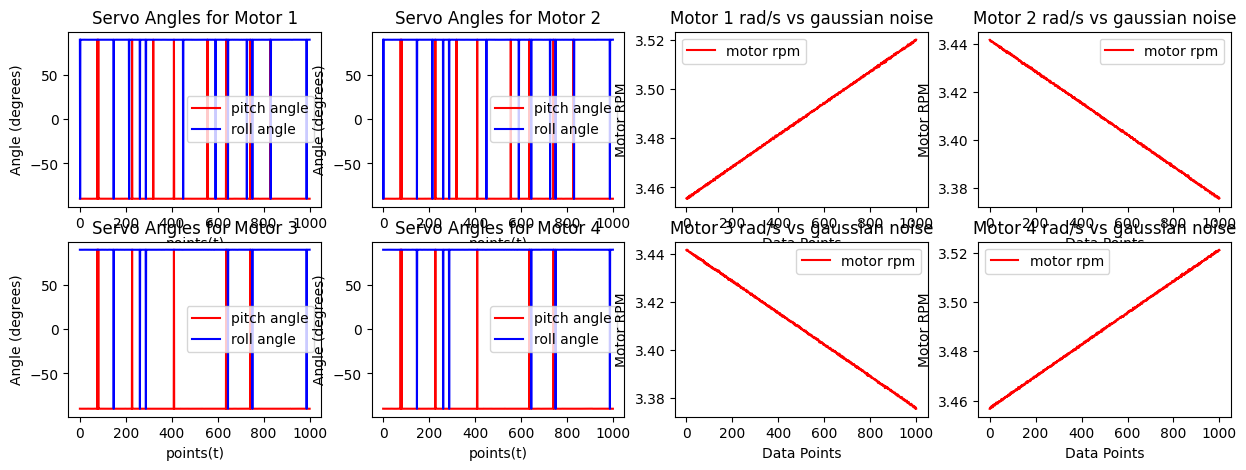

In [9]:
time = np.linspace(0,points,num=points).reshape((points,1))
fig,axes = plt.subplots(ncols=4, nrows=2, figsize=(15,5))
counter = 1
for row in range(2): 
    for col in range(2): 
        axes[row, col].plot(time, alphas[counter-1].T, color='red', label="pitch angle")
        axes[row, col].plot(time, betas[counter-1].T, color='blue', label="roll angle")
        axes[row, col].legend()
        axes[row, col].set_title(f"Servo Angles for Motor {counter}")
        axes[row, col].set_xlabel("points(t)")
        axes[row, col].set_ylabel("Angle (degrees)")
        counter+=1


axis = ["forward", "right", "throttle", "roll", "pitch", "yaw"]
counter = 0
for row in range(2): 
    for col in range(2,4): 
        axes[row, col].plot(time, omegas[counter-1].T, color='red', label="motor rpm")
        axes[row, col].legend()
        axes[row, col].set_title(f"Motor {counter +1} rad/s vs gaussian noise")
        axes[row, col].set_xlabel(f"Data Points")
        axes[row, col].set_ylabel("Motor RPM")
        counter+=1
plt.show()